## Configuración y datos experimentales 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

#### Algunas funciones para reutilizar código

In [4]:
def save_filtered_data(file_list, charge_range, output_dir):
    """
    Filters and saves segmented data from input files based on a charge range.
    Args:
        file_list (list of str): A list containing two file paths. The first file is assumed to be the source data (fuente) 
                                 and the second file is the background data (fondo).
        charge_range (tuple of int): A tuple containing two integers that define the lower and upper bounds of the charge range.
        output_dir (str): The directory where the filtered data will be saved.
    Returns:
        None
    The function reads data from the provided files, segments it into chunks of 32, filters these segments based on the 
    provided charge range, and saves the filtered segments into CSV files in the specified output directory. The source 
    data is saved as "fuente_pulsos.csv" and the background data is saved as "fondo_pulsos.csv".
    """
    fuente_data, fondo_data = [], []
    fuente_file, fondo_file = file_list
    for file, data_list in zip([fuente_file, fondo_file], [fuente_data, fondo_data]):
        data = np.loadtxt(file, np.int32, usecols=0)
        num_segments = len(data) // 32
        new_data = data[:num_segments * 32].reshape(-1, 32)

        for subsegment in new_data:
            if charge_range[0] < np.sum(subsegment) < charge_range[1]:
                data_list.append(subsegment)
        
    # Guardar los resultados en el directorio de salida
    os.makedirs(output_dir, exist_ok=True)
    if fuente_data:
        np.savetxt(os.path.join(output_dir, "fuente_pulsos.csv"), np.array(fuente_data), delimiter=',', fmt='%d')
    if fondo_data:
        np.savetxt(os.path.join(output_dir, "fondo_pulsos.csv"), np.array(fondo_data), delimiter=',', fmt='%d')
    
    print(f"Datos guardados en {output_dir}")
   

#### Archivos obtenidos con `download_files.py` (Ver `README.md`)

In [5]:
file_list_AmBe_desnuda = sorted(glob.glob('AmBe/*desnuda*'))
file_list_AmBe_plomo = sorted(glob.glob('AmBe/*plomo(10cm)*'))
file_list_AmBe_cdparafinab = sorted(glob.glob('AmBe/*cdparafb*'))

#### Fuente AmBe desnuda (neutrones + gamma)

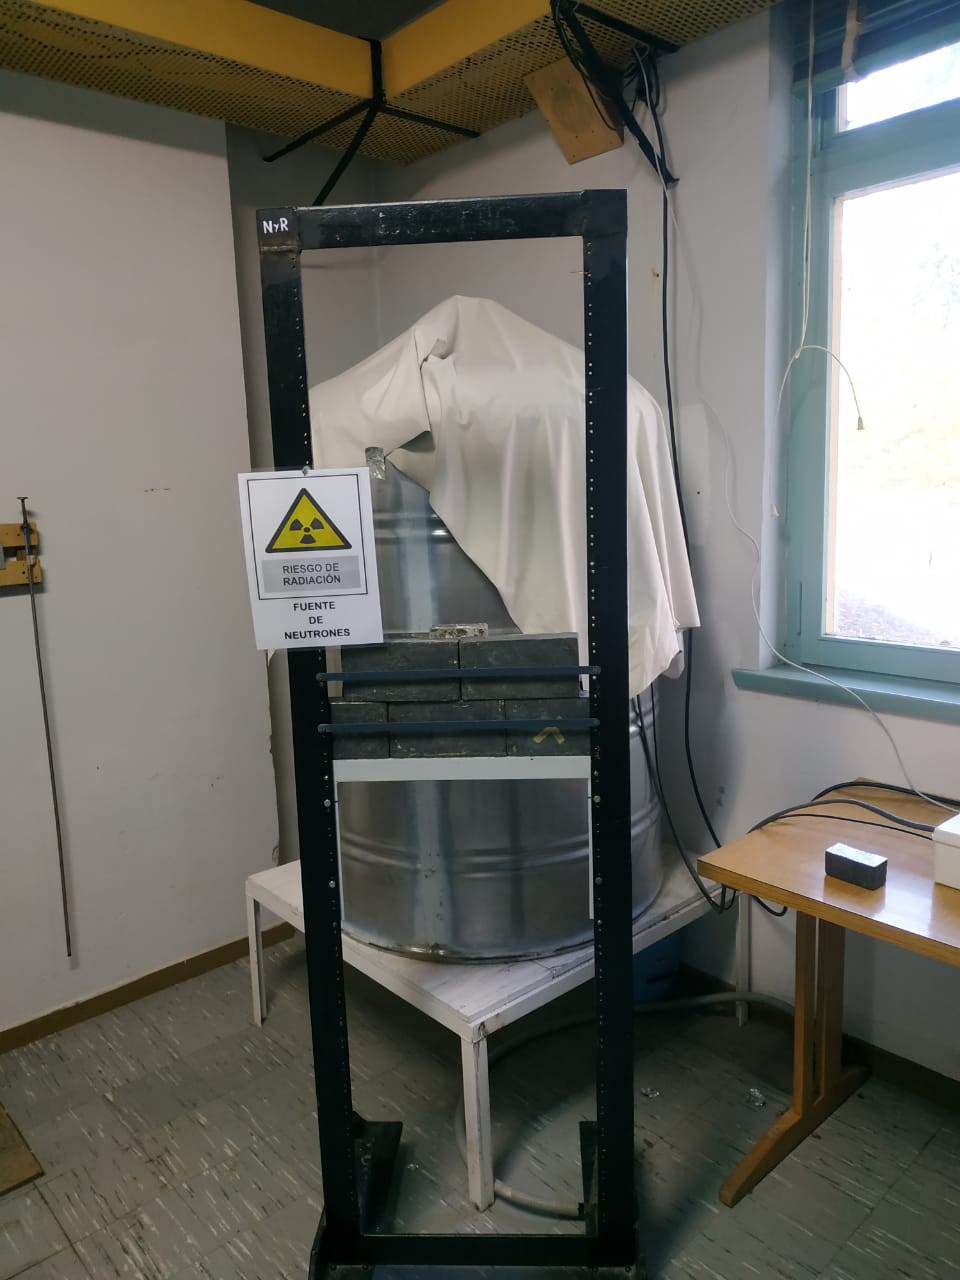

In [6]:
from IPython.display import Image

image_path = 'imgs/desnuda.jpg'

display(Image(filename=image_path, width=300, height=300))

In [ ]:
# Un rango del histograma de carga 4000 - 6000
charge_thresholds = (4000, 6000) 

save_filtered_data(file_list_AmBe_desnuda, charge_thresholds, "AmBe_desnuda_portion")

#### Fuente AmBe con blindaje Plomo (neutrones)

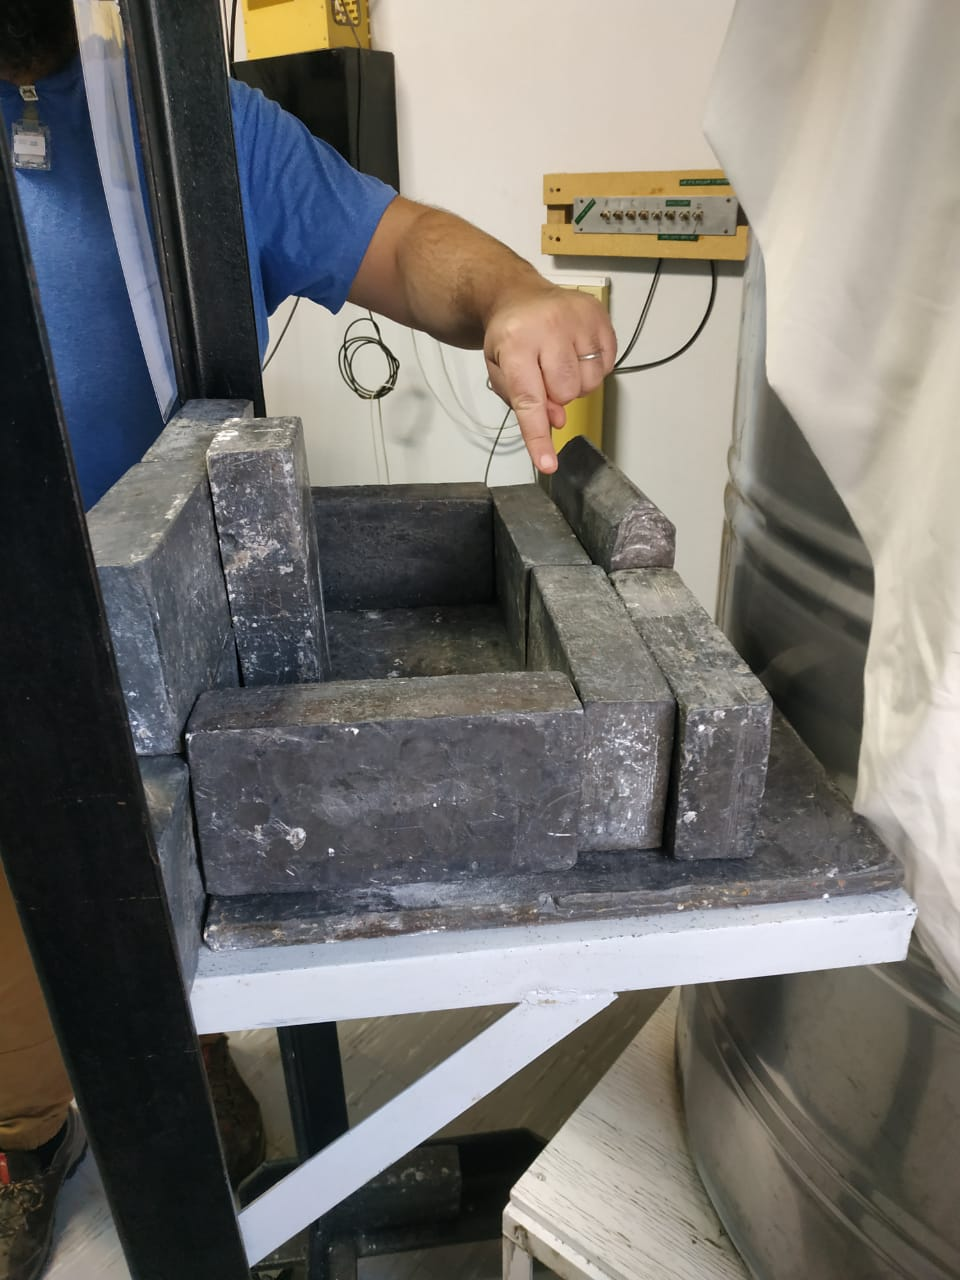

In [ ]:
image_path = 'imgs/plomo.jpg'

display(Image(filename=image_path, width=300, height=300))

In [ ]:
save_filtered_data(file_list_AmBe_plomo, charge_thresholds, "AmBe_plomo_portion") 

Datos guardados en AmBe_plomo_portion


#### Fuente AmBe con blidaje Parafina Borada + Cadmio (gammas)

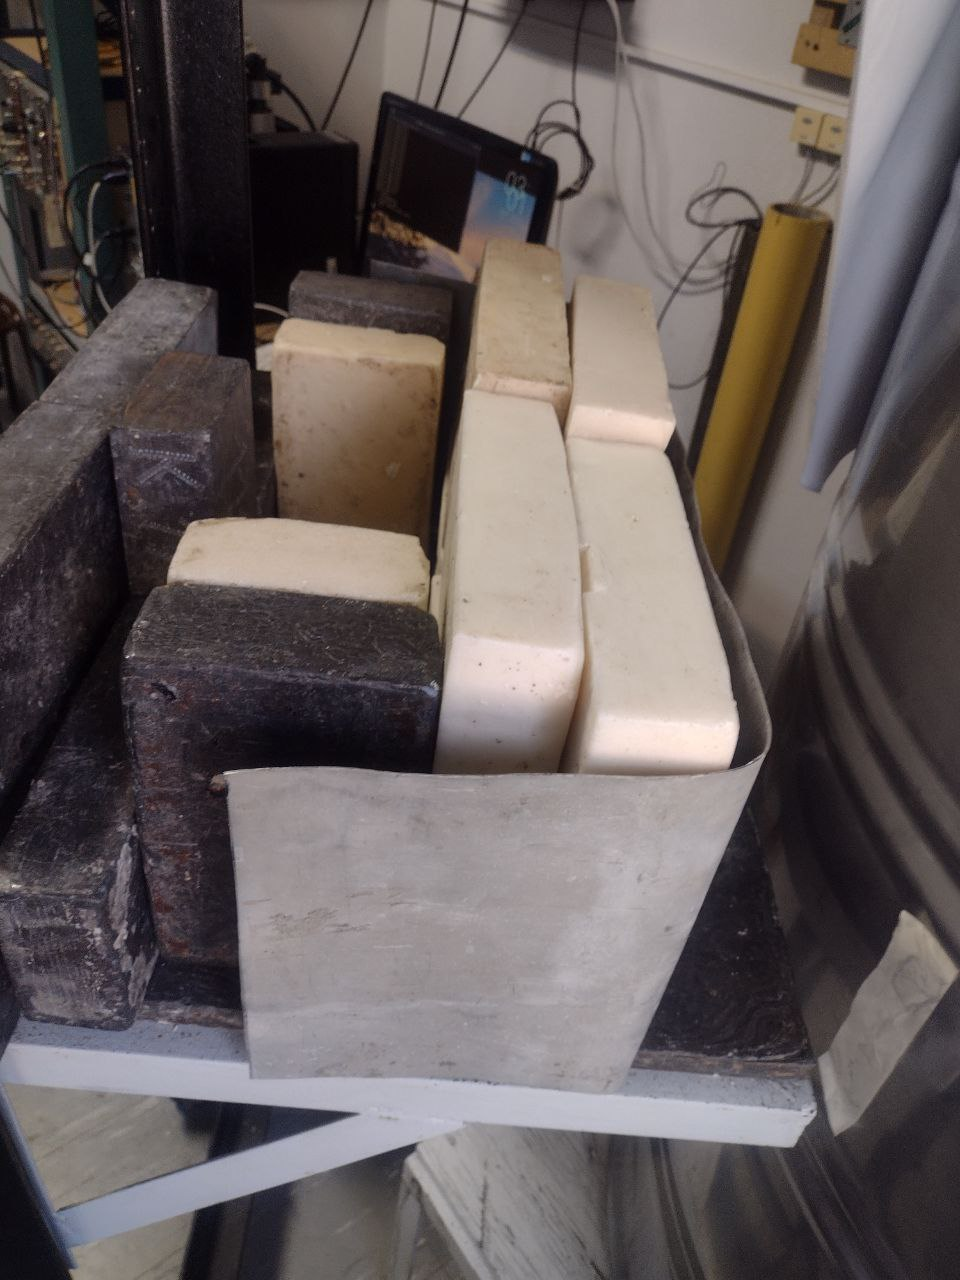

In [ ]:
image_path = 'imgs/cdpb.jpg'

display(Image(filename=image_path, width=300, height=300))

In [ ]:
save_filtered_data(file_list_AmBe_cdparafinab, charge_thresholds, "AmBe_cdparafinab_portion") 

Datos guardados en AmBe_cdparafinab_portion


## Análisis exploratorio de los datos

In [ ]:
# Función para contar eventos en archivos de fuente y fondo
def count_events_in_directory(directory):
    """
    Counts the number of events in 'fuente_pulsos.csv' and 'fondo_pulsos.csv' files within a given directory.
    Parameters:
    directory (str): The path to the directory containing the CSV files.
    Returns:
    tuple: A tuple containing three integers:
        - fuente_count (int): The number of events in 'fuente_pulsos.csv'.
        - fondo_count (int): The number of events in 'fondo_pulsos.csv'.
        - difference (int): The difference between fuente_count and fondo_count.
    """
    fuente_file = os.path.join(directory, "fuente_pulsos.csv")
    fondo_file = os.path.join(directory, "fondo_pulsos.csv")
    
    fuente_count = 0
    fondo_count = 0
    
    # Contar eventos de fuente si el archivo existe
    if os.path.exists(fuente_file):
        fuente_data = np.loadtxt(fuente_file, delimiter=',', dtype=np.int32)
        fuente_count = fuente_data.shape[0]  # Número de filas, cada una representa un evento de fuente

    # Contar eventos de fondo si el archivo existe
    if os.path.exists(fondo_file):
        fondo_data = np.loadtxt(fondo_file, delimiter=',', dtype=np.int32)
        fondo_count = fondo_data.shape[0]  # Número de filas, cada una representa un evento de fondo

    return fuente_count, fondo_count, fuente_count - fondo_count

# Directorios de las configuraciones 
directories = [
    "AmBe_desnuda_portion",
    "AmBe_plomo_portion",
    "AmBe_cdparafinab_portion"
]

# Obtener el conteo de eventos para la configuración "desnuda" portion
fuente_count_desnuda, fondo_count_desnuda, difference_desnuda = count_events_in_directory("AmBe_desnuda_portion")

print('Para el rango 4000 - 6000:\n')
# Contar y mostrar los resultados para cada configuración
for directory in directories:
    fuente_count, fondo_count, difference = count_events_in_directory(directory)
    
    # Calcular el porcentaje en relación a "desnuda" portion
    if fuente_count_desnuda > 0:
        percentage_difference = (difference / difference_desnuda) * 100
    else:
        percentage_difference = 0  
    
    print(f"Directorio: {directory}")
    print(f"  Fuente - Fondo: {difference}")
    print(f"  Porcentaje en relación a 'desnuda': {percentage_difference:.2f}%\n")

Para el rango 4000 - 6000:

Directorio: AmBe_desnuda_portion
  Fuente - Fondo: 601521
  Porcentaje en relación a 'desnuda': 100.00%

Directorio: AmBe_plomo_portion
  Fuente - Fondo: 129834
  Porcentaje en relación a 'desnuda': 21.58%

Directorio: AmBe_cdparafinab_portion
  Fuente - Fondo: 436804
  Porcentaje en relación a 'desnuda': 72.62%



#### Histograma de carga

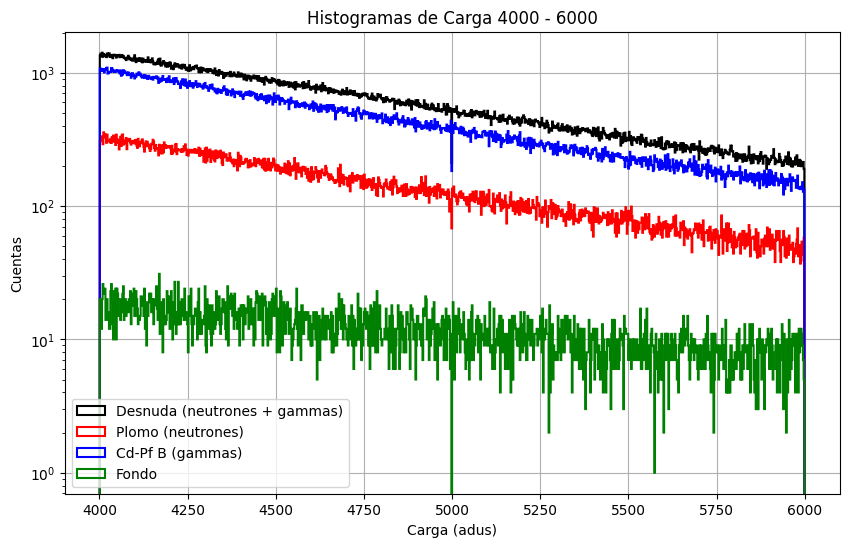

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Función para cargar los datos de los archivos y calcular la carga
def load_and_calculate_charge_from_directory(directory):
    """
    Loads data files from a specified directory, calculates the charge for each file, 
    and returns an array of all charges.
    Args:
        directory (str): The path to the directory containing the data files.
    Returns:
        np.ndarray: An array containing the calculated charges from all files.
    Notes:
        - The function assumes that the data files are in CSV format with integer values.
        - The charge is calculated as the sum of pulses (rows) in each file.
        - The function flattens the charges from all files into a single array.
    """
    files = sorted(glob.glob(f"{directory}"))
    all_charges = []
    
    for file in files:
        data = np.loadtxt(file, delimiter=',', dtype=np.int32)
        charges = np.sum(data, axis=1)  # Calcular la carga como la suma de los pulsos
        all_charges.extend(charges)  # Aplanar y agregar a la lista
        
    return np.array(all_charges)

# Cargar las cargas de las diferentes configuraciones
fuente_charges = load_and_calculate_charge_from_directory("AmBe_desnuda_portion/fuente_pulsos.csv")
fuente_charges_plomo = load_and_calculate_charge_from_directory("AmBe_plomo_portion/fuente_pulsos.csv")
fuente_charges_cdparafinab = load_and_calculate_charge_from_directory("AmBe_cdparafinab_portion/fuente_pulsos.csv")
fondo_charges = load_and_calculate_charge_from_directory("AmBe_desnuda_portion/fondo_pulsos.csv")

# Crear el gráfico
plt.figure(figsize=(10, 6))

plt.hist(fuente_charges, bins=1000, histtype='step', linewidth=1.5, label='Desnuda (neutrones + gammas)', color='black')
plt.hist(fuente_charges_plomo, bins=1000, histtype='step', linewidth=1.5, label='Plomo (neutrones)', color='red')
plt.hist(fuente_charges_cdparafinab, bins = 1000, histtype='step', linewidth=1.5, label='Cd-Pf B (gammas)', color='blue')
plt.hist(fondo_charges, bins = 1000, histtype='step', linewidth=1.5, label='Fondo', color='green')

plt.title('Histogramas de Carga 4000 - 6000')
plt.xlabel('Carga (adus)')
plt.ylabel('Cuentas')
plt.grid()
plt.legend()
plt.yscale('log')
plt.show()

#### Forma pulsos promedios antes del balanceo

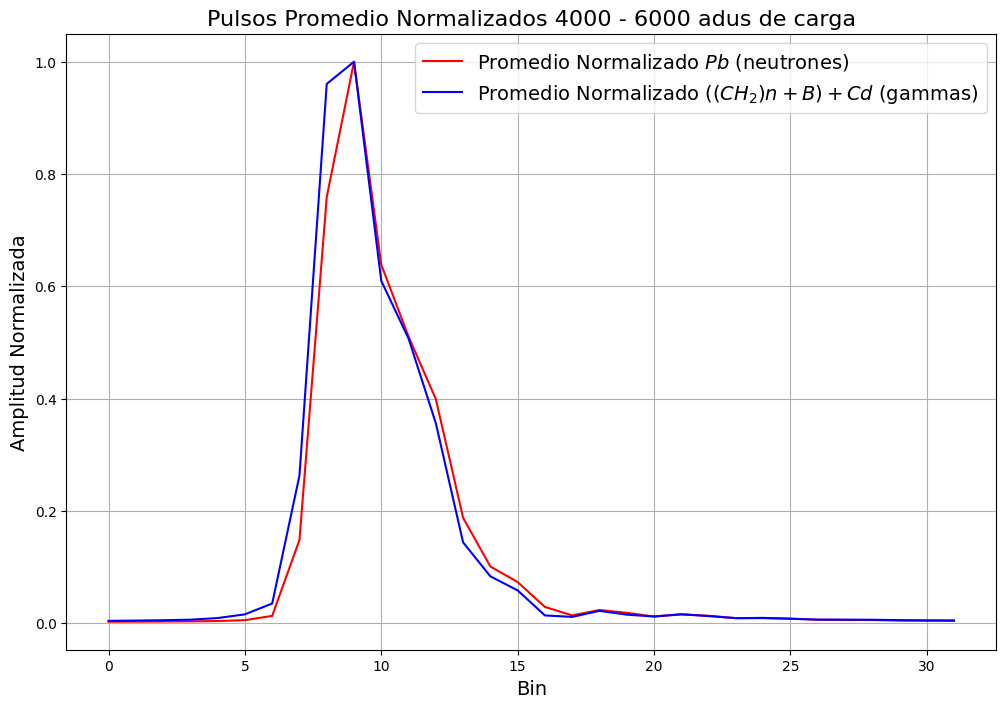

In [ ]:
# Función para cargar los datos de los archivos y calcular el promedio de los pulsos
def load_and_calculate_average_pulse_from_directory(directory):
    """
    Loads pulse data from CSV files in the specified directory, calculates the average pulse for each file, 
    and returns an array of average pulses.
    Args:
        directory (str): The path to the directory containing the CSV files. The files should be named with 
                         the pattern '*fuente_pulsos.csv'.
    Returns:
        np.ndarray: An array where each element is the average pulse calculated from a corresponding CSV file.
    """
    files = sorted(glob.glob(f"{directory}/*fuente_pulsos.csv"))
    average_pulses = []
    
    for file in files:
        data = np.loadtxt(file, delimiter=',', dtype=np.int32)
        average_pulse = np.mean(data, axis=0)  # Calcular el promedio de los pulsos
        average_pulses.append(average_pulse)  # Agregar el promedio a la lista
        
    return np.array(average_pulses)

# Función para normalizar pulsos
def normalize_pulses(pulses):
    """
    Normalize the given pulses by dividing each pulse by its maximum absolute value.

    Parameters:
    pulses (numpy.ndarray): A 2D array where each row represents a pulse.

    Returns:
    numpy.ndarray: A 2D array of the same shape as `pulses`, where each pulse is normalized.
    """
    return pulses / np.max(np.abs(pulses), axis=1, keepdims=True)

# Cargar los promedios de las diferentes configuraciones
average_pulses = load_and_calculate_average_pulse_from_directory("AmBe_desnuda_portion")
average_pulses_plomo = load_and_calculate_average_pulse_from_directory("AmBe_plomo_portion")
average_pulses_cdparafinab = load_and_calculate_average_pulse_from_directory("AmBe_cdparafinab_portion")

# Normalizar los pulsos promedio
normalized_average_pulses = normalize_pulses(average_pulses)
normalized_average_pulses_plomo = normalize_pulses(average_pulses_plomo)
normalized_average_pulses_cdparafinab = normalize_pulses(average_pulses_cdparafinab)

# Crear el gráfico
plt.figure(figsize=(12, 8))

x_values = np.arange(len(normalized_average_pulses[0]))  

# plt.plot(x_values, np.mean(normalized_average_pulses, axis=0), label='Promedio Normalizado Desnuda (neutrones + gammas)', color='black', linestyle='-')
plt.plot(x_values, np.mean(normalized_average_pulses_plomo, axis=0), label='Promedio Normalizado $Pb$ (neutrones)', color='red', linestyle='-')
plt.plot(x_values, np.mean(normalized_average_pulses_cdparafinab, axis=0), label='Promedio Normalizado $((CH_2)n + B) + Cd$ (gammas)', color='blue', linestyle='-')

plt.title('Pulsos Promedio Normalizados AmBe 4000 - 6000 adus de carga', fontsize=16)  
plt.xlabel('Bin', fontsize=14)  
plt.ylabel('Amplitud Normalizada', fontsize=14) 
plt.grid()
plt.legend(fontsize=14)
plt.show()

## Análisis estadístico de los datos

In [ ]:
import seaborn as sns
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

In [ ]:
# Balanceo de datos con variaciones de SMOTE y reducción de dimensionalidad 
def cargar_datos_balanceados(archivos_neutrones, archivos_gammas, metodo_sobremuestreo='smote'):
    # Cargar y concatenar datos como en tu función original
    pulsos_neutrones = [np.loadtxt(archivo, delimiter=',') for archivo in archivos_neutrones]
    pulsos_gammas = [np.loadtxt(archivo, delimiter=',') for archivo in archivos_gammas]
    pulsos_neutrones = np.vstack(pulsos_neutrones)
    pulsos_gammas = np.vstack(pulsos_gammas)
    
    labels = np.array([1] * pulsos_neutrones.shape[0] + [0] * pulsos_gammas.shape[0])
    data = np.vstack((pulsos_neutrones, pulsos_gammas))

    print(f"Before-balance: Neutrones: {np.sum(labels == 1)}, Gammas: {np.sum(labels == 0)}\n")
    # Escoger el método de sobremuestreo
    if metodo_sobremuestreo == 'borderline':
        sobremuestreo = BorderlineSMOTE(random_state=42)
    elif metodo_sobremuestreo == 'adasyn':
        sobremuestreo = ADASYN(random_state=42)
    else:
        sobremuestreo = SMOTE(random_state=42)

    # Aplicar sobremuestreo y submuestreo
    X_resampled, y_resampled = sobremuestreo.fit_resample(data, labels)
    X_resampled, y_resampled = TomekLinks().fit_resample(X_resampled, y_resampled)  # Remover ejemplos redundantes

    print(f"Post-balance: Neutrones: {np.sum(y_resampled == 1)}, Gammas: {np.sum(y_resampled == 0)}")
    return X_resampled, y_resampled
    # return data, labels

archivos_neutrones = ['AmBe_plomo_portion/fuente_pulsos.csv']  
archivos_gammas = ['AmBe_cdparafinab_portion/fuente_pulsos.csv']

# Cargar los datos balanceados
X, y = cargar_datos_balanceados(archivos_neutrones, archivos_gammas, 'smote')

Before-balance: Neutrones: 142725, Gammas: 449298

Post-balance: Neutrones: 447135, Gammas: 449298


#### Forma pulsos promedios luego del balanceo

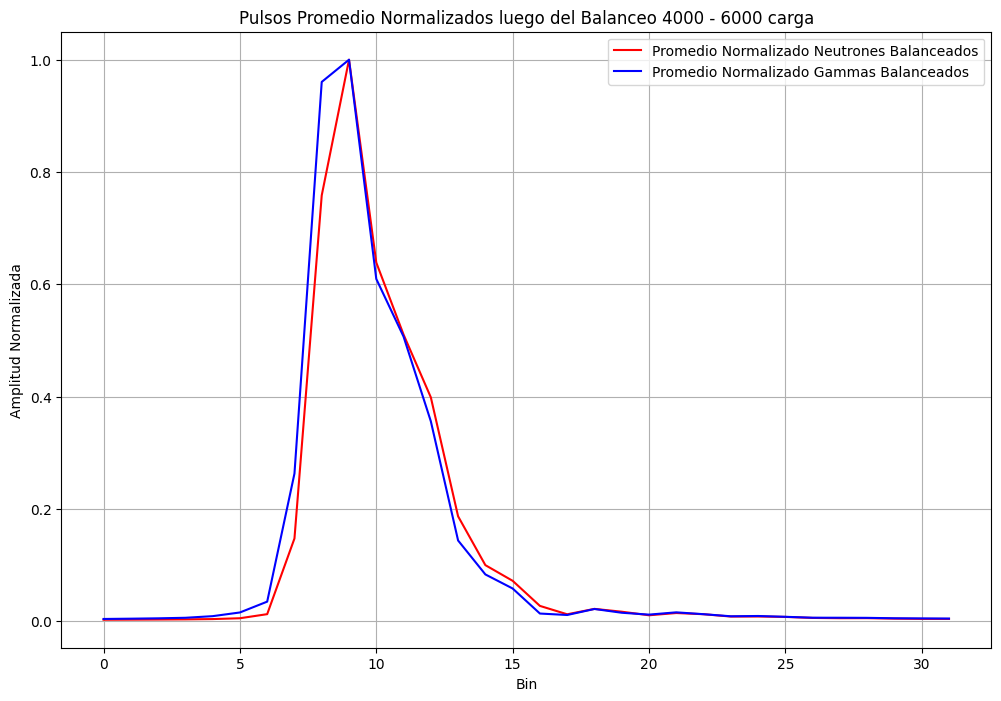

In [ ]:
# Calcular el promedio de los pulsos balanceados de neutrones y gammas
average_pulses_neutrones_balanceados = np.mean(X[y == 1], axis=0)  # Promedio de los pulsos balanceados para neutrones
average_pulses_gammas_balanceados = np.mean(X[y == 0], axis=0)  # Promedio de los pulsos balanceados para gammas

# Normalizar los pulsos promedio balanceados
normalized_average_pulses_neutrones_balanceados = average_pulses_neutrones_balanceados / np.max(np.abs(average_pulses_neutrones_balanceados))
normalized_average_pulses_gammas_balanceados = average_pulses_gammas_balanceados / np.max(np.abs(average_pulses_gammas_balanceados))

# Crear el gráfico para los pulsos promedio balanceados
plt.figure(figsize=(12, 8))

x_values = np.arange(len(normalized_average_pulses_neutrones_balanceados))  # Eje X basado en el tamaño de los datos

plt.plot(x_values, normalized_average_pulses_neutrones_balanceados, label='Promedio Normalizado Neutrones Balanceados', color='red', linestyle='-')
plt.plot(x_values, normalized_average_pulses_gammas_balanceados, label='Promedio Normalizado Gammas Balanceados', color='blue', linestyle='-')

plt.title('Pulsos Promedio Normalizados luego del Balanceo 4000 - 6000 carga')
plt.xlabel('Bin')
plt.ylabel('Amplitud Normalizada')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Escalado de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Análisis Estadístico Básico
print("Análisis estadístico de las características:")
print(pd.DataFrame(X_train).describe())

Análisis estadístico de las características:
                  0              1              2              3   \
count  717146.000000  717146.000000  717146.000000  717146.000000   
mean        0.000407       0.000071      -0.000257       0.000074   
std         1.005989       1.003447       0.999375       1.002076   
min        -4.613874      -4.402811      -3.457458      -3.032225   
25%        -0.418722      -0.395549      -0.373344      -0.359415   
50%        -0.029481      -0.041967      -0.054298      -0.071082   
75%         0.283928       0.246690       0.212763       0.178695   
max        27.866120      25.298071      22.846134      20.624795   

                  4              5              6              7   \
count  717146.000000  717146.000000  717146.000000  717146.000000   
mean        0.000330       0.000521       0.000710       0.000176   
std         1.001246       1.000390       1.002254       0.999708   
min        -2.749411      -1.751142      -1.627882      -

#### Análisis de Correlación

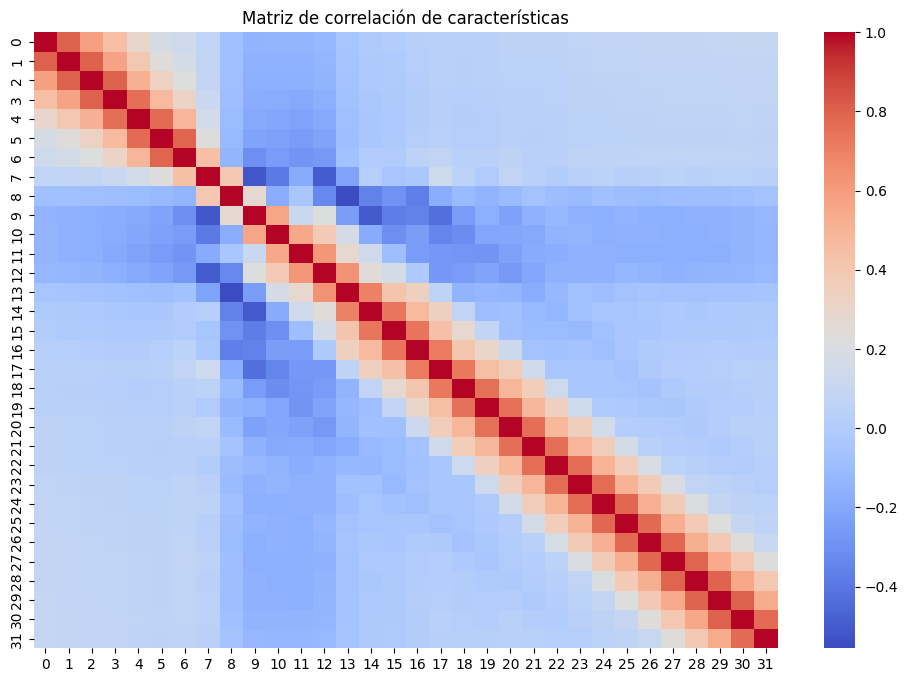

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X_train).corr(), cmap='coolwarm', annot=False)
plt.title("Matriz de correlación de características")
plt.show()

## Comparando clasificadores simples

In [ ]:
import logging
import warnings

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,  ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Clasificadores base a comparar

In [ ]:
classifiers = {
    "LinearSVC": LinearSVC(max_iter=1000, dual=False),
    "LGBMClassifier": LGBMClassifier(force_col_wise=True, verbose=-1),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(silent=True),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),              
    "RidgeClassifier": RidgeClassifier(),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis()  
}

In [ ]:
# Configurar logging para suprimir la salida de LightGBM
logging.getLogger('lightgbm').setLevel(logging.ERROR)

# Ignorar advertencias específicas de LightGBM
warnings.filterwarnings('ignore', category=UserWarning, module="lightgbm")
# Ignorar advertencias de scikit-learn
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
# Dict para almacenar los resultados
results = {
    "Classifier": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Log Loss": []
}

#### Entrenar y evaluar cada clasificador

In [ ]:
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_all = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None
    
    accuracy_all = accuracy_score(y_test, y_pred_all)
    precision = precision_score(y_test, y_pred_all, average="weighted")
    recall = recall_score(y_test, y_pred_all, average="weighted")
    f1 = f1_score(y_test, y_pred_all, average="weighted")
    log_loss_score = log_loss(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Guardar resultados
    results["Classifier"].append(clf_name)
    results["Accuracy"].append(accuracy_all)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)
    results["Log Loss"].append(log_loss_score)
    
    del clf
    gc.collect()

# Mostrar los resultados
print(pd.DataFrame(results))


                    Classifier  Accuracy  Precision    Recall  F1-Score  \
0                    LinearSVC  0.630129   0.631607  0.630129  0.629278   
1               LGBMClassifier  0.890912   0.909923  0.890912  0.889576   
2       RandomForestClassifier  0.902581   0.909747  0.902581  0.902122   
3   GradientBoostingClassifier  0.803042   0.804233  0.803042  0.802883   
4                XGBClassifier  0.887895   0.906427  0.887895  0.886544   
5           CatBoostClassifier  0.891303   0.909273  0.891303  0.890042   
6           LogisticRegression  0.629365   0.630461  0.629365  0.628749   
7       DecisionTreeClassifier  0.826602   0.826772  0.826602  0.826590   
8           AdaBoostClassifier  0.732697   0.735679  0.732697  0.731947   
9         ExtraTreesClassifier  0.885301   0.885393  0.885301  0.885299   
10             RidgeClassifier  0.630124   0.631614  0.630124  0.629265   
11  LinearDiscriminantAnalysis  0.630124   0.631614  0.630124  0.629265   

    Log Loss  
0        

#### Visualización de accuracies para cada clasificador usando todas las features vs usando las 5 mejores features de cada uno

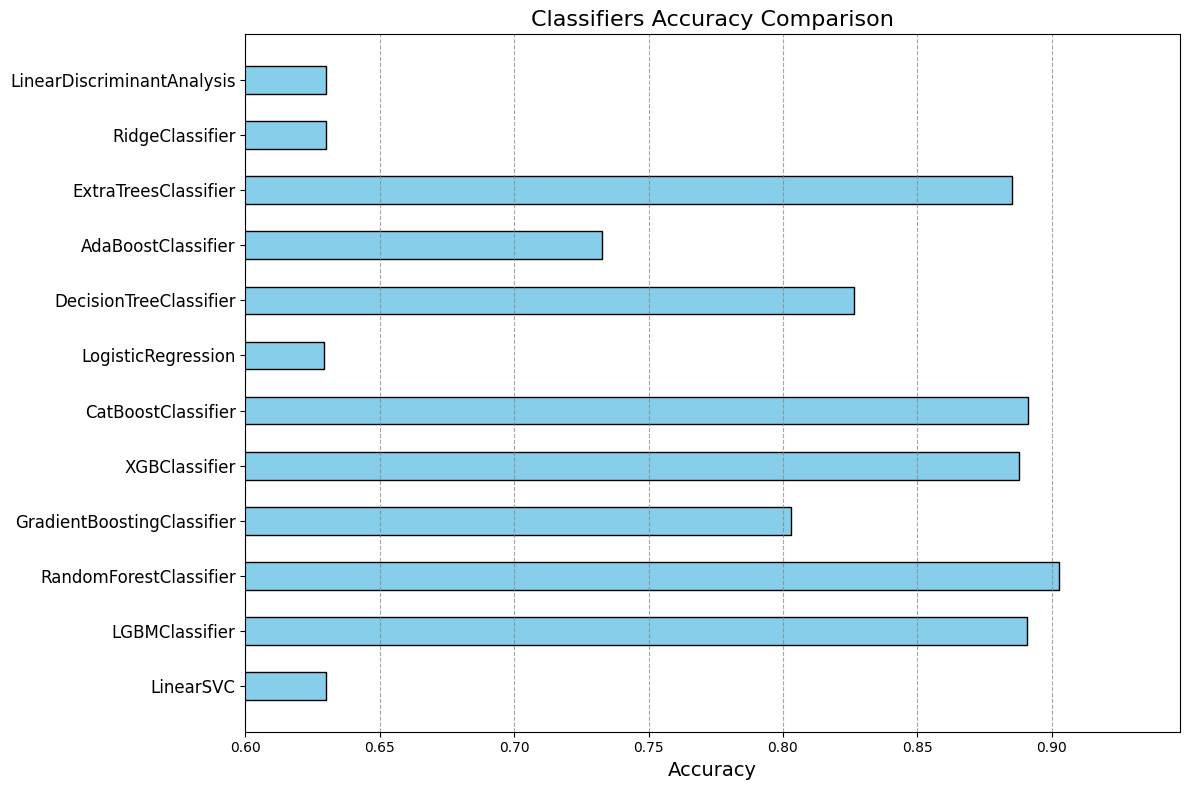

In [ ]:
x = np.arange(len(results["Classifier"]))
fig, ax = plt.subplots(figsize=(12, 8))

bars_all_acc = ax.barh(x, results["Accuracy"], color='skyblue', edgecolor='black', height=0.5)
ax.set_yticks(x)
ax.set_yticklabels(results["Classifier"], fontsize=12)
ax.set_xlabel("Accuracy", fontsize=14)
ax.set_title("Classifiers Accuracy Comparison", fontsize=16)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7)
plt.xlim(0.6,)
plt.tight_layout()
plt.show()

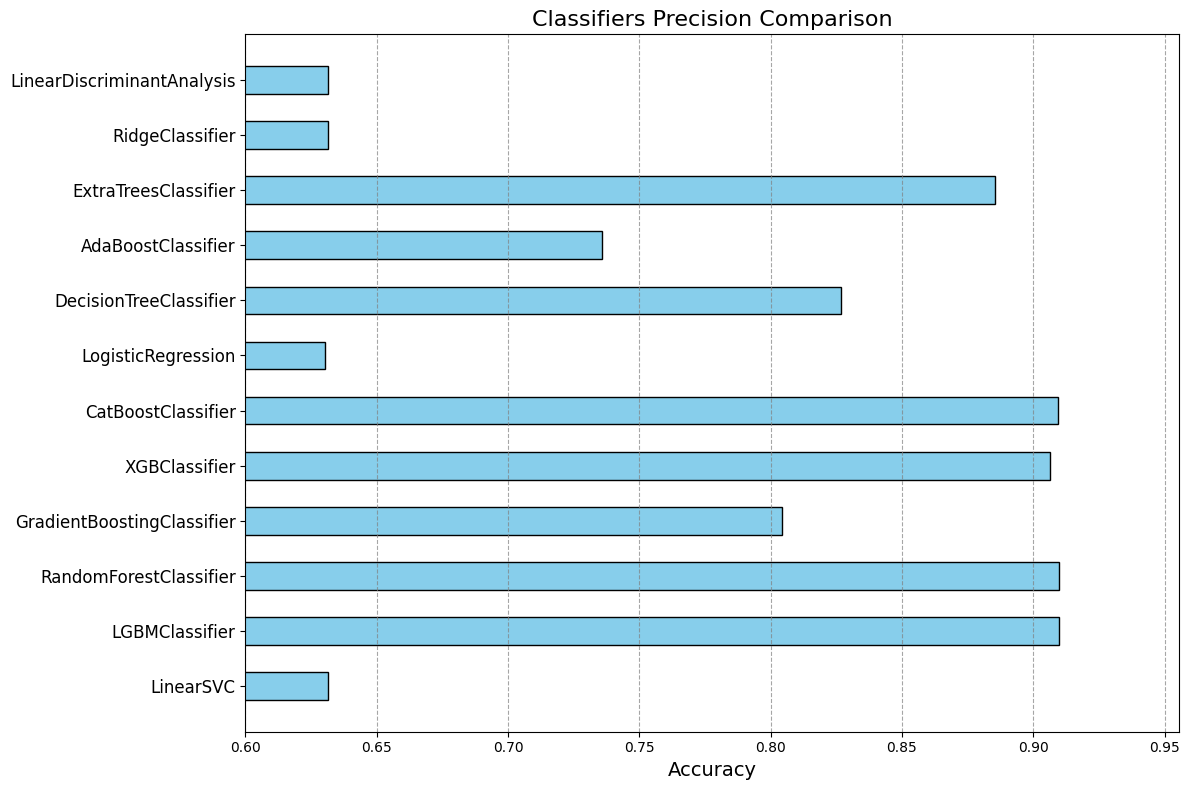

In [ ]:
x = np.arange(len(results["Classifier"]))
fig, ax = plt.subplots(figsize=(12, 8))

bars_all_acc = ax.barh(x, results["Precision"], color='skyblue', edgecolor='black', height=0.5)
ax.set_yticks(x)
ax.set_yticklabels(results["Classifier"], fontsize=12)
ax.set_xlabel("Accuracy", fontsize=14)
ax.set_title("Classifiers Precision Comparison", fontsize=16)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7)
plt.xlim(0.6,)
plt.tight_layout()
plt.show()

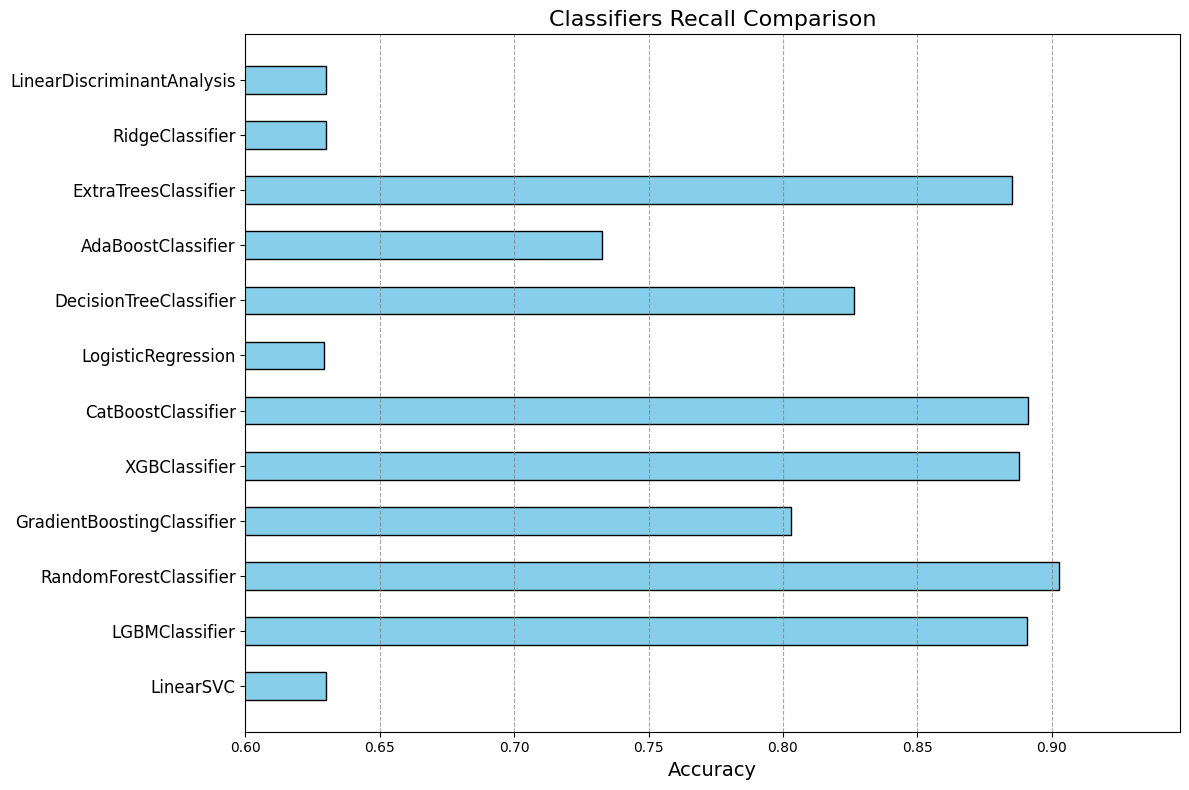

In [ ]:
x = np.arange(len(results["Classifier"]))
fig, ax = plt.subplots(figsize=(12, 8))

bars_all_acc = ax.barh(x, results["Recall"], color='skyblue', edgecolor='black', height=0.5)
ax.set_yticks(x)
ax.set_yticklabels(results["Classifier"], fontsize=12)
ax.set_xlabel("Accuracy", fontsize=14)
ax.set_title("Classifiers Recall Comparison", fontsize=16)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7)
plt.xlim(0.6,)
plt.tight_layout()
plt.show()

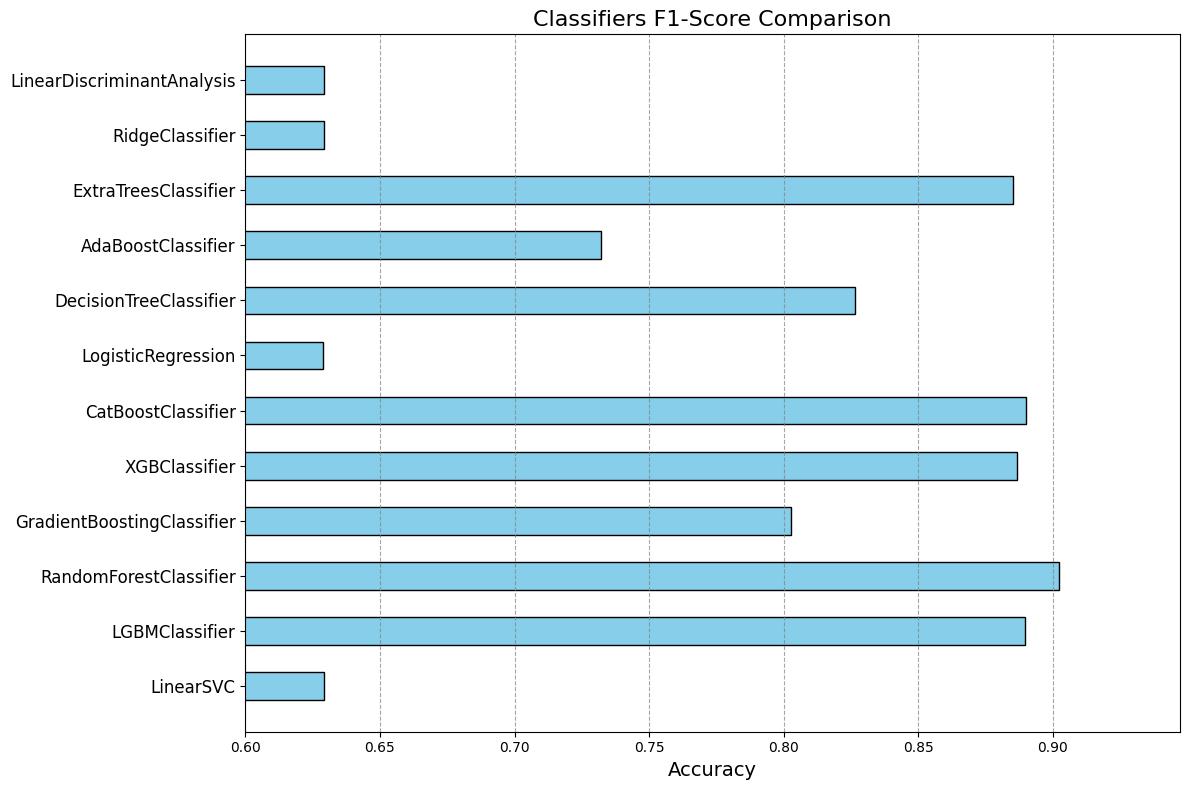

In [ ]:
x = np.arange(len(results["Classifier"]))
fig, ax = plt.subplots(figsize=(12, 8))

bars_all_acc = ax.barh(x, results["F1-Score"], color='skyblue', edgecolor='black', height=0.5)
ax.set_yticks(x)
ax.set_yticklabels(results["Classifier"], fontsize=12)
ax.set_xlabel("Accuracy", fontsize=14)
ax.set_title("Classifiers F1-Score Comparison", fontsize=16)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7)
plt.xlim(0.6,)
plt.tight_layout()
plt.show()

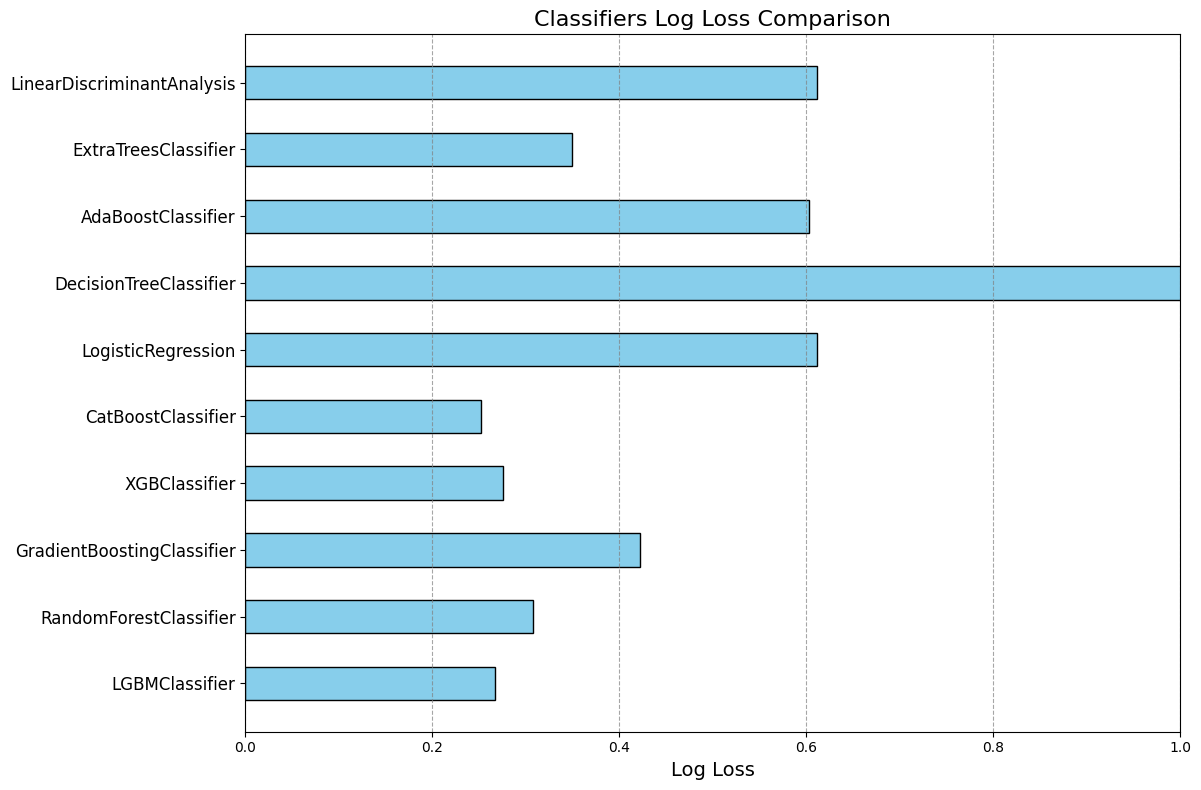

In [ ]:
import numpy as np

# Filtrar los valores NaN de Log Loss, asegurándonos de que los valores sean numéricos
filtered_results = {
    "Classifier": [clf for clf, loss in zip(results["Classifier"], results["Log Loss"]) 
                   if isinstance(loss, (int, float)) and not np.isnan(loss)],
    "Log Loss": [loss for loss in results["Log Loss"] 
                 if isinstance(loss, (int, float)) and not np.isnan(loss)],
}

# Crear el gráfico con los valores filtrados
x = np.arange(len(filtered_results["Classifier"]))
fig, ax = plt.subplots(figsize=(12, 8))

bars_log_loss = ax.barh(x, filtered_results["Log Loss"], color='skyblue', edgecolor='black', height=0.5)
ax.set_yticks(x)
ax.set_yticklabels(filtered_results["Classifier"], fontsize=12)
ax.set_xlabel("Log Loss", fontsize=14)
ax.set_title("Classifiers Log Loss Comparison", fontsize=16)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7)
plt.xlim(0, max(filtered_results["Log Loss"]) * 1.1)  # Ajustar el límite de x para que se vea bien
plt.tight_layout()
plt.xlim(0,1)
plt.show()
